In [1]:
from studies.study_factory import StudyFactory
from dataloader.dataloader import DataLoader
from itertools import chain
import random
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch


dataloader = DataLoader(
    buffer_size=10,
    max_cache_size_gb=100,
    cache_dir="cache",
    notch_filter=True,
    frequency_bands={"all": (0.5, 100)},
    scaling="both",
    delay=0.15,
    brain_clipping=20,
    baseline_window=0.5,
    new_freq=200,
    batch_types={"audio": 2},
    batch_kwargs={
        "audio": {
            "max_random_shift": 1,
            "window_size": 30,
            "window_stride": 1,
            "audio_sample_rate": 16000,
            "hop_length": 160,
            "audio_processor": "openai/whisper-large-v3",
        }
    },
)

study = StudyFactory.create_study(
    study_name="gwilliams2023",
    batch_type="audio",
    path="data/gwilliams2023",
    cache_enabled=True,
    max_cache_size=200,  # in items
    cache_name="cache",
)


flat_recordings = list(chain.from_iterable(chain.from_iterable(study.recordings)))

2025-01-18 21:10:06,499	INFO worker.py:1821 -- Started a local Ray instance.


Loading Gwilliams2023 with batch type audio


In [2]:
import time

dataloader.start_fetching([flat_recordings[0]], cache=True)

# Process batches as they become available
try:
    batches, recs, start_time = 0, 0, time.time()
    print(f"Total recordings: {len(flat_recordings)}")

    while True:
        batch = dataloader.get_recording()

        if batch is None:
            break

        brain = batch.brain_segments["all"]
        batches += brain.shape[0]
        recs += 1

        if recs % 1 == 0:
            print(
                f"Batch {batches} ({recs} recordings) processed in {time.time() - start_time:.2f}s"
            )
            print(
                f"Average processing time per recording: {(time.time() - start_time) / recs:.2f}s"
            )
            print(
                f"Average processing time per batch: {(time.time() - start_time) / batches:.2f}s"
            )

        break

except KeyboardInterrupt:
    print("Interrupted")
    dataloader.stop()
except Exception as e:
    print("Error", e)
    dataloader.stop()

Total recordings: 196
Batch 134 (1 recordings) processed in 3.83s
Average processing time per recording: 3.83s
Average processing time per batch: 0.03s


Raw signal shape: torch.Size([1, 208, 6000])
Time taken: 0.27s
Shape of spectrogram: torch.Size([1, 208, 128, 3001])
Size of tensor: 0.32 GB
Estimated num batches per cpu: 21.90


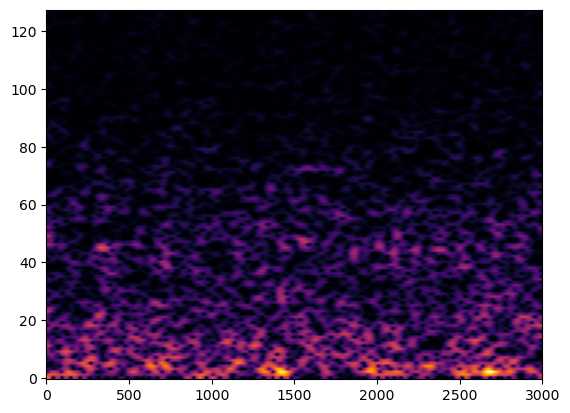

In [3]:
import time

device = "cpu"

raw = batch.brain_segments["all"][:1]
print(f"Raw signal shape: {raw.shape}")

n_fft = 256
bins = 128
t = raw.shape[-1]

spectrogram_transform = T.Spectrogram(
    n_fft=n_fft,
    hop_length=2,
    normalized=True,
    power=2,
).to(device)

start_time = time.time()
spec = torch.log1p(spectrogram_transform(raw.to(device)))
spec = spec[:, :, :bins, :t]
print(f"Time taken: {time.time() - start_time:.2f}s")
print(f"Shape of spectrogram: {spec.shape}")

plt.imshow(spec[0][0].numpy(), aspect="auto", origin="lower", cmap="inferno")
tensor_size = spec.numel() * spec.element_size() / 1e9
print(f"Size of tensor: {tensor_size:.2f} GB")
print(f"Estimated num batches per cpu: {7 / tensor_size:.2f}")

In [5]:
# model_config = SpectralConvConfig(
#     # Str to list of possible conditions
#     mel_normalization=False,
#     conditions={
#         "study": [],
#         "subject": [],
#     },
#     # Channels
#     in_channels=208,
#     out_channels=128,
#     hidden_dim=384,
#     dropout=0.2,
#     initial_group_norm=True,
#     # Sensor layout settings
#     layout_dim=2,
#     layout_proj=True,
#     layout_scaling="minmax",
#     # Merger with spatial attn
#     merger=True,
#     merger_emb_type="fourier",
#     merger_emb_dim=2048,
#     merger_channels=256,
#     merger_dropout=True,
#     merger_conditional=None,
#     # Inital
#     initial_linear=384,
#     initial_depth=1,
#     # Conditional layers
#     conditional_layers=False,
#     conditional_layers_dim=None,  # input or hidden_dim
#     # Conv layer overall structure
#     cnn_channels=[384, 384, 256, 128, 64, 32, 16, 8, 1],
#     kernel_size=3,
#     dilation_growth=2,
#     dilation_period=5,
#     glu=1,
#     conv_dropout=0.2,
#     dropout_input=0.2,
#     group_norm=True,
#     half=True,
#     cnn_pos_encoding=True,
#     mels=128,
#     # Quantizer
#     quantizer=False,
#     num_codebooks=0,
#     codebook_size=0,
#     quantizer_commitment=0,
#     quantizer_temp_init=0,
#     quantizer_temp_min=0,
#     quantizer_temp_decay=0,
#     # Transformers Encoders
#     transformer_input=None,
#     transformer_encoder_emb=None,
#     transformer_encoder_layers=0,
#     transformer_encoder_heads=0,
#     # Transformer Decoders
#     transformer_decoder_emb=None,
#     transformer_decoder_layers=0,
#     transformer_decoder_heads=0,
#     transformer_decoder_dim=0,
# )

# model = SpectralConv(model_config).to("mps")

SpectralConv initialized with 9404471 parameters, cond: ['study', 'subject']
Merger True, merger channels 256
ConvBlocks: [384, 384, 256, 128, 64, 32, 16, 8, 1], hidden_dim: 384, params 8710966


In [6]:
# recording = batch.recording

# input = torch.cat([spec, spec], dim=-1).to("mps")
# print(f"Input shape: {input.shape}")

# out = model(
#     x=[input],
#     recording=[recording],
#     conditions=[
#         {
#             "study": "gwilliams",
#             "subject": f"{recording.study_name}_{recording.subject_id}",
#         },
#     ],
#     mel=[],
#     return_hidden_outputs=False,
# )

Input shape: torch.Size([1, 208, 128, 6000])


In [7]:
# out[0].shape

torch.Size([1, 128, 3000])

In [46]:
# model_conv = SpectralConvSequence(
#     channels=[384, 384, 256, 128, 64, 32, 16, 8, 1],
#     kernel=3,
#     dilation_growth=2,
#     dilation_period=5,
#     stride=1,
#     dropout=0.2,
#     decode=False,
#     group_norm=True,
#     dropout_input=0.2,
#     glu=1,
#     activation=nn.GELU,
#     half=False,
#     pos_encoding=True,
#     mels=128,
# ).to("mps")

In [ ]:
# from models.simpleconv import SimpleConv
# from config import SimpleConvConfig

# model_config = SimpleConvConfig(
#     # Str to list of possible conditions
#     mel_normalization=False,
#     conditions={
#         "study": [],
#         "subject": [],
#     },
#     # Channels
#     in_channels=208,
#     out_channels=128,
#     hidden_dim=384,
#     dropout=0.2,
#     initial_batch_norm=True,
#     # Sensor layout settings
#     layout_dim=2,
#     layout_proj=True,
#     layout_scaling="minmax",
#     # Merger with spatial attn
#     merger=False,
#     merger_emb_type=None,
#     merger_emb_dim=0,
#     merger_channels=0,
#     merger_dropout=False,
#     merger_conditional=None,
#     # Inital
#     initial_linear=384,
#     initial_depth=1,
#     # Conditional layers
#     conditional_layers=False,
#     conditional_layers_dim=None,  # input or hidden_dim
#     # Conv layer overall structure
#     depth=6,
#     kernel_size=3,
#     growth=1.0,
#     dilation_growth=2,
#     dilation_period=5,
#     glu=1,
#     conv_dropout=0.2,
#     dropout_input=0.2,
#     batch_norm=True,
#     half=False,
#     cnn_pos_encoding=True,
#     # Quantizer
#     quantizer=False,
#     num_codebooks=0,
#     codebook_size=0,
#     quantizer_commitment=0,
#     quantizer_temp_init=0,
#     quantizer_temp_min=0,
#     quantizer_temp_decay=0,
#     # Transformers Encoders
#     transformer_input=None,
#     transformer_encoder_emb=None,
#     transformer_encoder_layers=0,
#     transformer_encoder_heads=0,
#     # Transformer Decoders
#     transformer_decoder_emb=None,
#     transformer_decoder_layers=0,
#     transformer_decoder_heads=0,
#     transformer_decoder_dim=0,
# )

# model_3 = SimpleConv(model_config)